# Import necessary libraries

In [95]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pickle



# Load dataset

In [96]:
df = pd.read_csv('train.csv') 



# Step 1: Check for missing values

In [97]:
print("Missing values in each column:\n", df.isnull().sum())


Missing values in each column:
 Patient_ID                 0
Age                        0
Marital_Status             0
Year of Operation          0
Positive_Axillary_Nodes    0
Tumor_Size                 0
Radiation_Therapy          0
Chemotherapy               0
Hormone_Therapy            0
Survival_Status            0
dtype: int64


# Step 2: Encode categorical variables

In [98]:
# Step 2: Encode categorical variables
label_encoder = LabelEncoder()
df['Marital_Status'] = label_encoder.fit_transform(df['Marital_Status'])  # Convert Marital_Status to numeric
df['Radiation_Therapy'] = df['Radiation_Therapy'].map({'Yes': 1, 'No': 0})  # Convert 'Yes'/'No' to 1/0
df['Chemotherapy'] = df['Chemotherapy'].map({'Yes': 1, 'No': 0})
df['Hormone_Therapy'] = df['Hormone_Therapy'].map({'Yes': 1, 'No': 0})

# Step 3: Define features and target

In [99]:
X = df.drop(columns=['Patient_ID', 'Survival_Status'])  # Remove non-relevant columns
y = df['Survival_Status']  # Target variable

# Step 4: Normalize features

In [100]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Recursive Feature Elimination (RFE)


In [101]:
""" # Instantiate the model
gbc = GradientBoostingClassifier(random_state=42)
# Apply RFE to select the top 5 most important features (you can adjust the number of features)
rfe = RFE(estimator=gbc, n_features_to_select=5, step=1)
X_rfe = rfe.fit_transform(X_scaled, y)

# Check selected features
selected_features = X.columns[rfe.support_]
print("Selected Features using RFE:", selected_features) """

' # Instantiate the model\ngbc = GradientBoostingClassifier(random_state=42)\n# Apply RFE to select the top 5 most important features (you can adjust the number of features)\nrfe = RFE(estimator=gbc, n_features_to_select=5, step=1)\nX_rfe = rfe.fit_transform(X_scaled, y)\n\n# Check selected features\nselected_features = X.columns[rfe.support_]\nprint("Selected Features using RFE:", selected_features) '

# Step 5: Add polynomial features

In [102]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Step 6: Reconfirm Train-test split

In [103]:
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)


# Step 7: Define the parameter grid for Gradient Boosting



In [104]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}


# Step 8: Use RandomizedSearchCV for hyperparameter tuning

In [105]:
gbc = GradientBoostingClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid, 
                                   n_iter=50, cv=5, scoring='accuracy', verbose=2, 
                                   random_state=42, n_jobs=-1)
random_search.fit(X_train_poly, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse'],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

# Step 9: Get the best model and fit it

In [106]:
best_gbc = random_search.best_estimator_
best_gbc.fit(X_train_poly, y_train)


GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_split=10, n_estimators=500,
                           random_state=42)

# Step 10: Evaluate the model

In [107]:
y_pred_poly = best_gbc.predict(X_test_poly)
print(f'Accuracy: {accuracy_score(y_test, y_pred_poly)}')
print(f'Precision: {precision_score(y_test, y_pred_poly)}')
print(f'Recall: {recall_score(y_test, y_pred_poly)}')
print(f'F1 Score: {f1_score(y_test, y_pred_poly)}')



Accuracy: 0.49
Precision: 0.5
Recall: 0.4444444444444444
F1 Score: 0.47058823529411764


# Step 11: Feature importance analysis


In [108]:
feature_importances = best_gbc.feature_importances_
features = poly.get_feature_names_out(input_features=X.columns)  # Get feature names after polynomial transformation


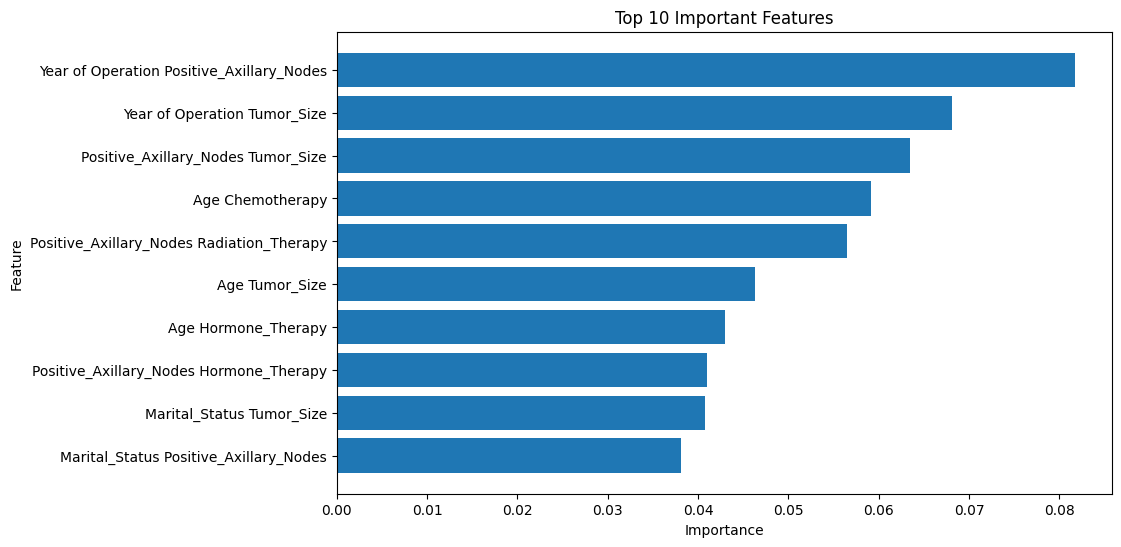

In [109]:
# Sort and plot the top 10 most important features
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
top_features = importance_df.nlargest(10, 'Importance')

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()
plt.show()

# Save the model to disk
with open('best_gbc_model.pkl', 'wb') as file:
    pickle.dump(best_gbc, file)